<a href="https://colab.research.google.com/github/DiaaEssam/Support_Vector_Machine_Implementation/blob/main/SVM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Separable Case

# Importing libraries

In [1]:
import numpy as np    
from scipy.optimize import Bounds, BFGS                     
from scipy.optimize import LinearConstraint, minimize   
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import sklearn.datasets as dt
from math import log, e, sqrt,comb

# Generating our linear separable dataset

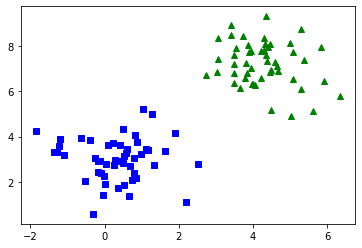

In [2]:
import matplotlib.pyplot as plt
from sklearn import datasets

X, y = datasets.make_blobs(n_samples=100, centers=2, n_features=2, center_box=(0, 10),random_state=1)
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'g^')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs')
plt.show()

In [3]:
print(X[0:10])

[[5.03562768 4.90170624]
 [0.8473044  2.16380979]
 [2.72610624 6.69877907]
 [4.40031478 7.96525611]
 [2.52946945 2.77469095]
 [0.80300478 3.06989302]
 [0.68121359 2.70352413]
 [0.79395061 2.399795  ]
 [3.06960087 8.34796864]
 [4.65873819 7.12767322]]


In [4]:
print(y[:10])

[0 1 0 0 1 1 1 1 0 0]


In [5]:
# we will use Lagrange Multipliers method to minimize our objective function which is in our case f(w,b)=||w||^2/2
# Lagrange Multipliers method takes the objective function and add it to it's constraints (they could be equality constraints or inequality constraints)
# we then multiply each constraint by a Lagrange Multiplier which is in our case alpha
# we then take the derivative of each variable in our lagrange function and they are (w,b,alpha)
# we then substitute by each result in our lagrange function and that would give us the dual lagrangian which is a Quadratic programming problem
# we can use  minimize() function in scipy.optimize to solve this problem and get the alphas but we have to initialize them first randomly
# then we get the parameters w and b

# Converting each label with 0 label to -1

In [6]:
y[y==0]=-1

In [7]:
print(y[:10])

[-1  1 -1 -1  1  1  1  1 -1 -1]


# Splitting the dataset into the Training set and Test set

In [8]:
from sklearn.model_selection import train_test_split
X_train ,X_test ,y_train ,y_test=train_test_split(X , y, test_size=0.25,random_state=0)
print(X_train.shape,y_train.shape)
print(X_test.shape)
print("")

(75, 2) (75,)
(25, 2)



# Epsilon is a very small number that's needed later on

In [9]:
epsilon = 1e-3

# lagrange_dual function

In [10]:
def lagrange_dual(alpha, x, y,dim):
    # result to hold final result of lagrange_dual
    result_v=np.zeros(x.shape[0]).reshape(1,-1)
    # indexes of support vectors
    ind_sv = np.where(alpha > epsilon)[0]
    for i in ind_sv:
      result_v+= alpha[i]*alpha*y[i]*y*((np.dot((x[i]).reshape(-1,1).T,x.T))**dim)
    result_v = 0.5*result_v - alpha    
    return np.sum(result_v.reshape(-1,1),axis=0)[0]

# Defining the Constraints

## Defining the Linear Constraints (first constraint)


summation of alphas multiplied by labels must equal to zero, then alphas would equal to zero 

we use linear_constraint to implement this constraint 

0 = summation of alphas * labels = 0

The first matrix (labels) is the first parameter in the LinearConstraint() method. The left and right bounds are the second and third arguments.

## Defining the Bounds (second constraint)

The bounds on alpha are defined using the Bounds() method. All alphas are constrained to lie between 0 and C (positive)

# Function to Find Alphas

In [11]:
def optimize_alpha(x, y, C,dim):
    m, n = x.shape
    np.random.seed(1)
    # Initialize alphas to random values
    alpha_0 = np.random.rand(m)*C
    # Define the constraint
    linear_constraint = LinearConstraint(y, [0], [0])
    # Define the bounds
    bounds_alpha = Bounds(np.zeros(m), np.full(m, C))
    # Find the optimal value of alpha
    result = minimize(lagrange_dual, alpha_0, args = (x, y,dim), method='trust-constr', 
                      hess=BFGS(), constraints=[linear_constraint],
                      bounds=bounds_alpha)
    # The optimized value of alpha lies in result.x
    alpha = result.x
    return alpha

# Getting parameters w,b

In [12]:
# we will get w based on the formula given from the dual lagrangian
def calculate_w(alpha, y, x):
    w=alpha.reshape(-1,1)*y.reshape(-1,1)*x        
    return np.sum(w,axis=0)
 
def calculate_b(alpha, y, x, w, C,dim):
    C_numeric = C-epsilon
    # Indices of support vectors with alpha<C
    ind_sv = np.where((alpha > epsilon)&(alpha < C_numeric))[0]
    # Take the average    
    b=y[np.where((alpha > epsilon)&(alpha < C_numeric))[0]]-(np.dot(x[np.where((alpha > epsilon)&(alpha < C_numeric))[0]],w))**dim
    b = b / len(ind_sv)
    return np.sum(b)

# Classifying Points


In [13]:
def classify_points(x, w, b,dim):
    # get y(x)
    predicted_labels = np.sum((x*w)**dim, axis=1) + b
    # sign method is used for: if array value is greater than 0 it returns 1, if array value is less than 0 it returns -1, and if array value 0 it returns 0.
    predicted_labels = np.sign(predicted_labels)
    # Assign a label arbitrarily a -1 if it is zero
    predicted_labels[predicted_labels==0] = -1
    return predicted_labels
 
def misclassification_rate(labels, predictions):
    total = len(labels)
    errors = sum(labels != predictions)
    return errors/total

# Measuring Generalization error

In [14]:
def Gen_Error(empirical_err,x,VC,delta):
  Gen_err=[]
  # based on the video and some websites
  Gen_err.append(empirical_err + sqrt((8/x.shape[0]) * log(((4 * (2 * x.shape[0])**VC)+1)/delta)))
  # based on book and doctor
  Gen_err.append(empirical_err + sqrt((2 * VC * log((e * x.shape[0]) / VC)) / x.shape[0]) + sqrt(log(1 / delta) /2 * x.shape[0]))
  # choose maximum Generalization error
  return max(Gen_err)

# Plotting the Margin and Hyperplane




In [15]:
def plot_hyperplane(w, b):
    x_coord = np.array(plt.gca().get_xlim())
    y_coord = -b/w[1] - w[0]/w[1] * x_coord
    plt.plot(x_coord, y_coord, color='red')

def plot_margin(w, b):
    x_coord = np.array(plt.gca().get_xlim())
    ypos_coord = 1/w[1] - b/w[1] - w[0]/w[1] * x_coord
    plt.plot(x_coord, ypos_coord, '--', color='green') 
    yneg_coord = -1/w[1] - b/w[1] - w[0]/w[1] * x_coord
    plt.plot(x_coord, yneg_coord, '--', color='magenta')

In [16]:
def plot_x(x, y, alpha=[], C=0):
    sns.scatterplot(x=x[:,0],y=x[:, 1], style=y,
    hue=y, markers=['s', 'P'],
    palette=['magenta', 'green'])
    if len(alpha) > 0:
        alpha_str = np.char.mod('%.1f', np.round(alpha, 1))
        ind_sv = np.where(alpha > epsilon)[0]
        for i in ind_sv:   
            plt.gca().text(x[i,0], x[i, 1]-.25, alpha_str[i] )

# Run and train the SVM for different cases

In [17]:
def display_SVM_result(x, y, C,dim,kernel):
    # Get the alphas
    alpha = optimize_alpha(x, y, C,dim)
    # Get the weights
    w = calculate_w(alpha, y, x)
    b = calculate_b(alpha, y, x, w, C,dim)
    if not kernel:
      plot_x(x, y, alpha, C)
      xlim = plt.gca().get_xlim()
      ylim = plt.gca().get_ylim()
      plot_hyperplane(w, b)
      plot_margin(w, b)
      plt.xlim(xlim)
      plt.ylim(ylim)
    # measuring VC dimension, combination(n+k,n)
    if kernel:
       VC=comb(w.shape[0]+dim,w.shape[0])
    # measuring VC dimension, VC=d+1
    else:
      VC=w.shape[0]+1
    # measuring delta
    delta = 0.5
    # Training 
    predictions = classify_points(x, w, b,dim)
    empirical_err = misclassification_rate(y, predictions)
    Gen_Error_Calc=Gen_Error(empirical_err,x,VC,delta)
    title = 'C = ' + str(C) + ',  Gen_Error: ' + '{:.1f}'.format(Gen_Error_Calc) + '%' + ',  VC= ' + str(VC)
    title = title + ',  total SV = ' + str(len(alpha[alpha > epsilon]))
    if not kernel:
      plt.title(title)
    return w,b,dim,title

# Run and train the SVM for separable case (hard margin)

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


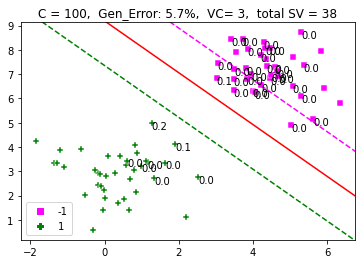

In [18]:
w,b,dim,_=display_SVM_result(X_train, y_train, 100,1,False)    
plt.show()

# Testing

In [19]:
y_pred=classify_points(X_test, w, b,dim).astype(int)
print(np.concatenate((y_pred.reshape(len(y_pred),1),y_test.reshape(len(y_test),1)),1))

[[ 1  1]
 [-1 -1]
 [-1 -1]
 [ 1  1]
 [-1 -1]
 [-1 -1]
 [ 1  1]
 [-1 -1]
 [-1 -1]
 [ 1  1]
 [ 1  1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [ 1  1]
 [-1 -1]
 [ 1  1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [ 1  1]
 [ 1  1]
 [-1 -1]
 [ 1  1]
 [ 1  1]]


# Plotting the decision boundary

In [20]:
def plot_decision_boundary (x_train,y_train,w,b,dim):
  Features_names=['X1','X2']
  Target_names=np.array(['Negative','Positive','dummy name'])
  custom_cmap = ListedColormap(['#b4a7d6','#93c47d'])
  formatter = plt.FuncFormatter(lambda i, *args: Target_names[int(i)])
  x0, x1 = np.meshgrid(
      np.linspace(x_train[:,0].min(), x_train[:, 0].max(), 500).reshape(-1, 1),
      np.linspace(x_train[:, 1].min(), x_train[:, 1].max(), 500).reshape(-1, 1)
  )

  X_new = np.c_[x0.ravel(), x1.ravel()]
  y_pred = classify_points(X_new,w,b,dim)
  zz = y_pred.reshape(x0.shape)

  plt.figure(figsize=(10, 5))
  plt.contourf(x0, x1, zz, cmap=custom_cmap)
  plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
  plt.colorbar(ticks=[0, 1, 2], format=formatter)

  plt.xlabel(Features_names[0])
  plt.ylabel(Features_names[1])
  plt.title("Decision boundary of SVM")
  plt.tight_layout()
  plt.show()

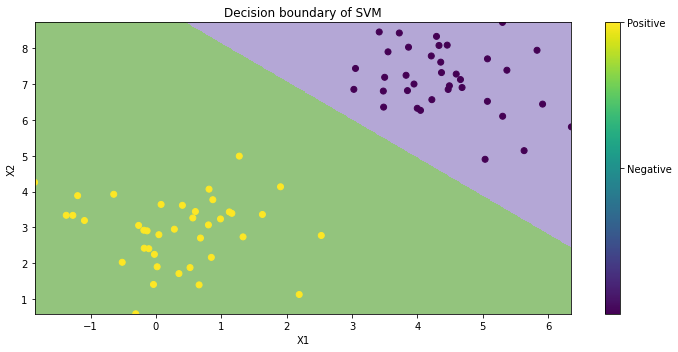

In [21]:
plot_decision_boundary(X_train,y_train,w,b,dim)

# Non_Separable Case

# Generating our non-linear separable dataset

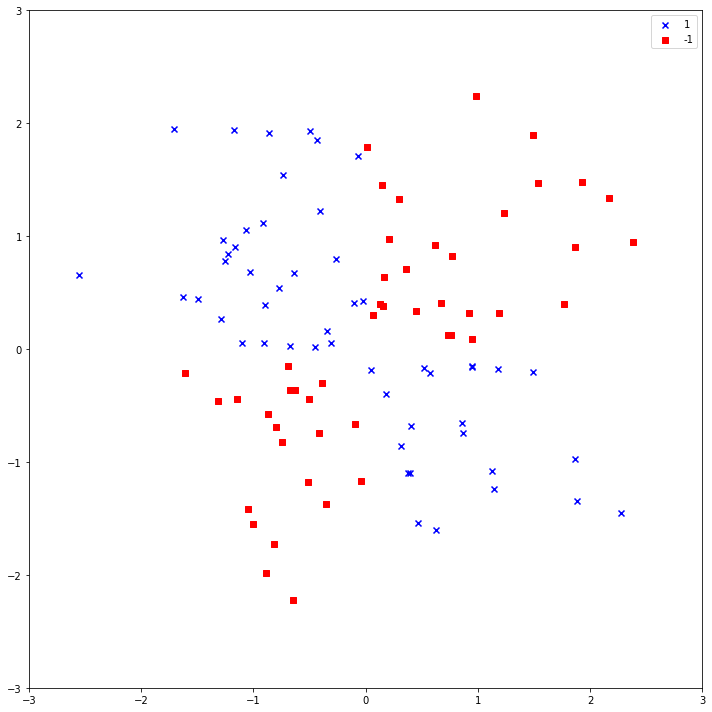

In [22]:
np.random.seed(0)
X = np.random.randn(100, 2)
y = np.logical_xor(X[:, 0] > 0,
                       X[:, 1] > 0)
y = np.where(y, 1, -1)

fig = plt.figure(figsize=(10,10))
plt.scatter(X[y == 1, 0],
            X[y == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X[y == -1, 0],
            X[y == -1, 1],
            c='r',
            marker='s',
            label='-1')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [23]:
print(X[0:10])

[[ 1.76405235  0.40015721]
 [ 0.97873798  2.2408932 ]
 [ 1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721]
 [-0.10321885  0.4105985 ]
 [ 0.14404357  1.45427351]
 [ 0.76103773  0.12167502]
 [ 0.44386323  0.33367433]
 [ 1.49407907 -0.20515826]
 [ 0.3130677  -0.85409574]]


In [24]:
print(y[:10])

[-1 -1  1  1  1 -1 -1 -1  1  1]


# Splitting the dataset into the Training set and Test set

In [25]:
X_train ,X_test ,y_train ,y_test=train_test_split(X , y, test_size=0.25,random_state=0)
print(X_train.shape,y_train.shape)
print(X_test.shape)
print("")

(75, 2) (75,)
(25, 2)



# Run and train the SVM for non-separable case (soft margin)

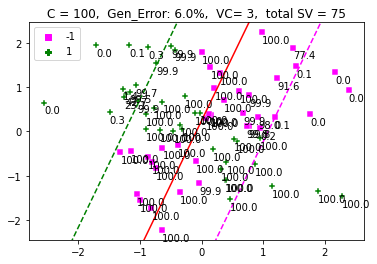

In [26]:
w,b,dim,_=display_SVM_result(X_train, y_train, 100,1,False)    
plt.show()

# Testing

In [27]:
y_pred=classify_points(X_test, w, b,dim).astype(int)
print(np.concatenate((y_pred.reshape(len(y_pred),1),y_test.reshape(len(y_test),1)),1))

[[ 1 -1]
 [-1  1]
 [-1  1]
 [-1 -1]
 [ 1  1]
 [ 1  1]
 [ 1 -1]
 [ 1  1]
 [-1 -1]
 [ 1  1]
 [ 1 -1]
 [-1  1]
 [-1  1]
 [-1  1]
 [-1 -1]
 [ 1 -1]
 [ 1 -1]
 [ 1 -1]
 [ 1  1]
 [-1  1]
 [-1  1]
 [ 1 -1]
 [-1  1]
 [-1 -1]
 [ 1  1]]


# Plotting the decision boundary

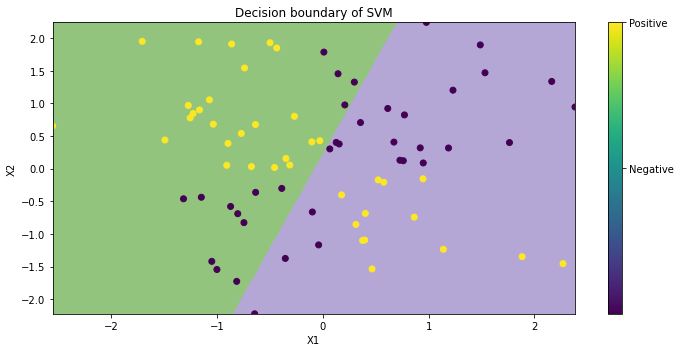

In [28]:
plot_decision_boundary(X_train,y_train,w,b,dim)

# Kernel with dimension 8

# Run and train for non-separable kernel case 

In [29]:
w,b,dim,title=display_SVM_result(X_train, y_train, 100,8,True)
print(title)

C = 100,  Gen_Error: 7.0%,  VC= 45,  total SV = 36


# Testing

In [30]:
y_pred=classify_points(X_test, w, b,dim).astype(int)
print(np.concatenate((y_pred.reshape(len(y_pred),1),y_test.reshape(len(y_test),1)),1))

[[-1 -1]
 [ 1  1]
 [ 1  1]
 [ 1 -1]
 [-1  1]
 [ 1  1]
 [ 1 -1]
 [ 1  1]
 [ 1 -1]
 [ 1  1]
 [-1 -1]
 [-1  1]
 [ 1  1]
 [-1  1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [ 1 -1]
 [ 1  1]
 [ 1  1]
 [ 1  1]
 [-1 -1]
 [ 1  1]
 [-1 -1]
 [-1  1]]


# Plotting the decision boundary

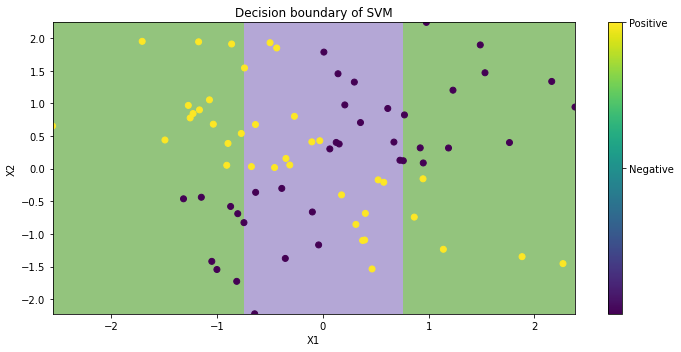

In [31]:
plot_decision_boundary(X_train,y_train,w,b,dim)